<a href="https://colab.research.google.com/github/a-bratosin/anomaly-detection-with-pyod/blob/main/TIA_Tema_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TIA Tema 2: Detectarea anomaliilor în funcționarea unei nave spațiale
## Bratosin Andrei, grupa 333AB


# 1. Alegerea setului de date

Pentru realizarea temei de detecție a anomaliilor, am ales să folosesc setul de date [Shuttle (Statlog)](https://archive.ics.uci.edu/dataset/148/statlog+shuttle) din baza de date de la UCI. Acesta conține 9 atribute de tip întreg, cât și un câmp de tip "categorie", cu numere de la 1 la 7, corespunzând la 7 stări posibile de funcționare . Am ales acest set de date din următoarele considerente:
- **Proporționarea datelor**: Cum am menționat anterior, itemii setului de date sunt împărțiți în 7 clase; cu toate acestea, așa cum este menționat și pe site-ul UCI,, marea majoritate a datelor fac parte din clasa 1 ("Rad flow"). Așadar, clasa 1 poate fi considerată drept clasa normală, iar clasele 2-7 drept anomalii. Setul de date a fost folosit sub această interpretare în numeroase articole de detectare de anomalii, precum [Abe et al. 2006](https://dl.acm.org/doi/abs/10.1145/1150402.1150459) sau [Liu et al. 2008](https://ieeexplore.ieee.org/document/4781136);
- **Interpretabilitatea datelor**: Spre deosebire de alte seturi de date concepute pentru clasificare/clustering, toate feature-urile setului de date sunt numite, fiind astfel mai ușor de atribuit semnificație fizică rezultatelor.

Mai întâi, importez în notebook setul de date, folosindu-mă de librăria de Python realizată de UCI:

In [ ]:
%pip install ucimlrepo
%pip install pyod
from ucimlrepo import fetch_ucirepo

# Importez setul de date pe baza id-ului său
statlog_shuttle = fetch_ucirepo(id=148)

# data (as pandas dataframes)
X = statlog_shuttle.data.features.copy()
y = statlog_shuttle.data.targets.copy()

# metadata
print(statlog_shuttle.metadata)

# variable information
print(statlog_shuttle.variables)
print(y)

{'uci_id': 148, 'name': 'Statlog (Shuttle)', 'repository_url': 'https://archive.ics.uci.edu/dataset/148/statlog+shuttle', 'data_url': 'https://archive.ics.uci.edu/static/public/148/data.csv', 'abstract': 'The shuttle dataset contains 9 attributes all of which are numerical. Approximately 80% of the data belongs to class 1', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 58000, 'num_features': 7, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': None, 'last_updated': 'Fri Feb 16 2024', 'dataset_doi': '10.24432/C5WS31', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Approximately 80% of the data belongs to class 1. Therefore the default accuracy is about 80%. The aim here is to obtain an accuracy of 99 - 99.9%.\r\n\r\nThe examples in the original dataset were in time or

# 2. Preprocesarea și explorarea datelor
Mai întâi, doresc să vizualizez distribuția etichetelor din setul de date original:


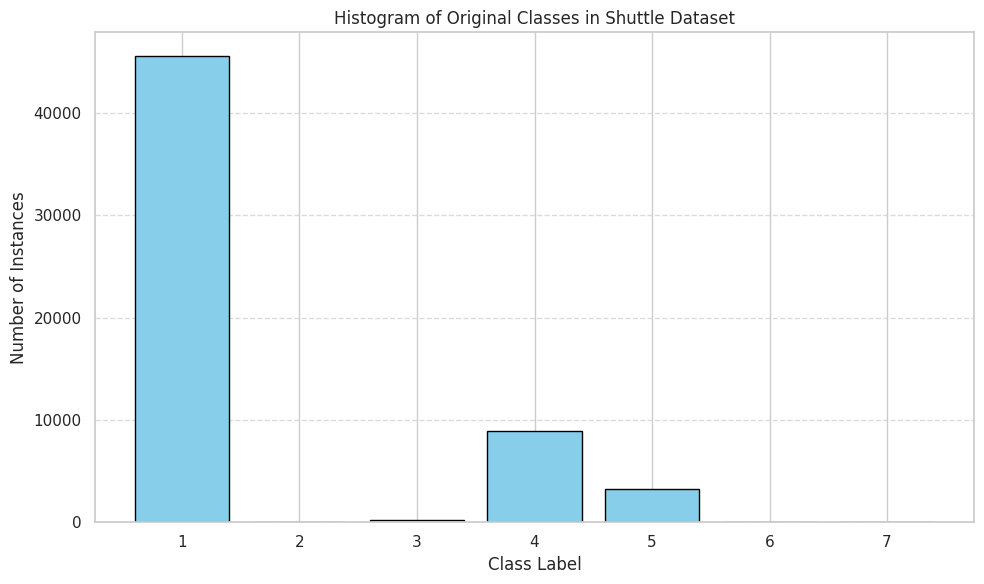

In [ ]:
import matplotlib.pyplot as plt

# Get the original class distribution
original_classes = statlog_shuttle.data.targets['class']

# Plot the histogram
plt.figure(figsize=(10, 6))
original_classes.hist(bins=range(1, 9), align='left', rwidth=0.8, color='skyblue', edgecolor='black')
plt.title('Histogram of Original Classes in Shuttle Dataset')
plt.xlabel('Class Label')
plt.ylabel('Number of Instances')
plt.xticks(range(1, 8)) # Set x-ticks for each class label
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

De aici, reiese că majoritatea etichetelor din setul de date aparțin clasei 1, înglobând majoritatea covârșitoare a elementelor din setul de date.

Dacă împărțim setul de date în normal/anomalie așa cum este, obținem o distribuție de 80%-20% între elementele normale și cele cu anomalii ale setului de date. Pentru majoritatea algoritmilor nesupervizați de detectare de anomalii, acest procentaj este mult prea mare pentru obținerea unor rezultate pertinente: Anomaliile fiind atât de numeroase, ajung să fie considerate o parte a datelor normale.

Așadar, o modificare făcută des pe acest set de date (modificare pe care o fac și eu) este eliminarea datelor care aparțin clasei cu #4, fiind a doua cea mai comună clasă din set. Cu această modificare, incidența datelor cu anomalii din set scade de la 20% la 7%, o proporție pentru care algoritmii nesupervizați de detecție a erorilor tind să funcționeze mult mai bine.

--- Analysis with all classes (Class 4 included as anomaly) ---
Total instances: 58000
Anomaly %: 21.40%

--- Analysis with Class 4 dropped ---
New X shape: (49097, 7)
New y shape: (49097,)
Normal (0) instances: 45586 (92.85%)
Anomaly (1) instances: 3511 (7.15%)


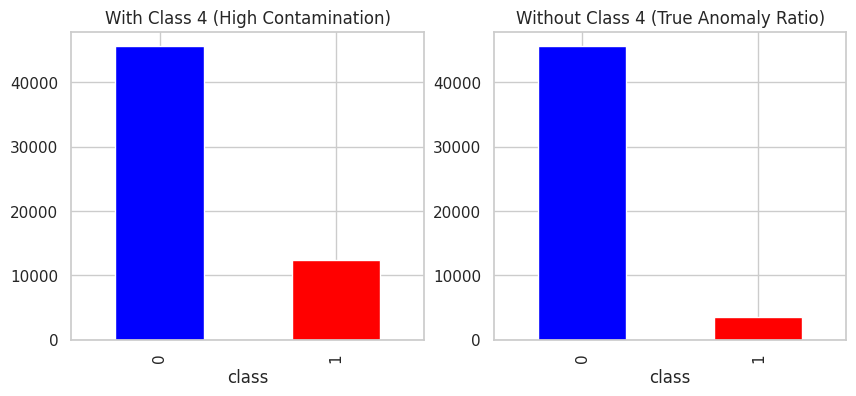

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Identify the indices to keep (where class is NOT 4)
# This creates a boolean mask that we can apply to both X and y
keep_mask = y['class'] != 4

# 2. Create the filtered instances
X_no4 = X[keep_mask].copy()          # The feature matrix without Class 4 rows
y_no4_filtered_df = y[keep_mask].copy() # The labels without Class 4 rows

# --- Case 1: All classes (Original logic) ---
print("--- Analysis with all classes (Class 4 included as anomaly) ---")
y_target_all = y['class'].apply(lambda x: 0 if x == 1 else 1)

total_all = y_target_all.count()
normal_count_all = y_target_all[y_target_all == 0].count()
anomaly_count_all = y_target_all[y_target_all == 1].count()

print(f"Total instances: {total_all}")
print(f"Anomaly %: {(anomaly_count_all/total_all)*100:.2f}%")

# --- Case 2: Class #4 dropped (Modified for X consistency) ---
print("\n--- Analysis with Class 4 dropped ---")

# Define binary target for the filtered data
y_target_no4 = y_no4_filtered_df['class'].apply(lambda x: 0 if x == 1 else 1)

total_no4 = y_target_no4.count()
normal_count_no4 = y_target_no4[y_target_no4 == 0].count()
anomaly_count_no4 = y_target_no4[y_target_no4 == 1].count()

print(f"New X shape: {X_no4.shape}")
print(f"New y shape: {y_target_no4.shape}")
print(f"Normal (0) instances: {normal_count_no4} ({(normal_count_no4/total_no4)*100:.2f}%)")
print(f"Anomaly (1) instances: {anomaly_count_no4} ({(anomaly_count_no4/total_no4)*100:.2f}%)")

# Update global variables for training
X = X_no4.copy()
y = y_target_no4.to_frame(name='Target')

# Visualization (keeping your histogram logic)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
y_target_all.value_counts().sort_index().plot(kind='bar', color=['blue', 'red'])
plt.title('With Class 4 (High Contamination)')

plt.subplot(1, 2, 2)
y_target_no4.value_counts().sort_index().plot(kind='bar', color=['blue', 'red'])
plt.title('Without Class 4 (True Anomaly Ratio)')
plt.show()

Pentru a estima separabilitatea datelor cu/fără anomalii, am realizat mai multe scatter plot-uri între câteva perechi de trăsăruri ale datelor:

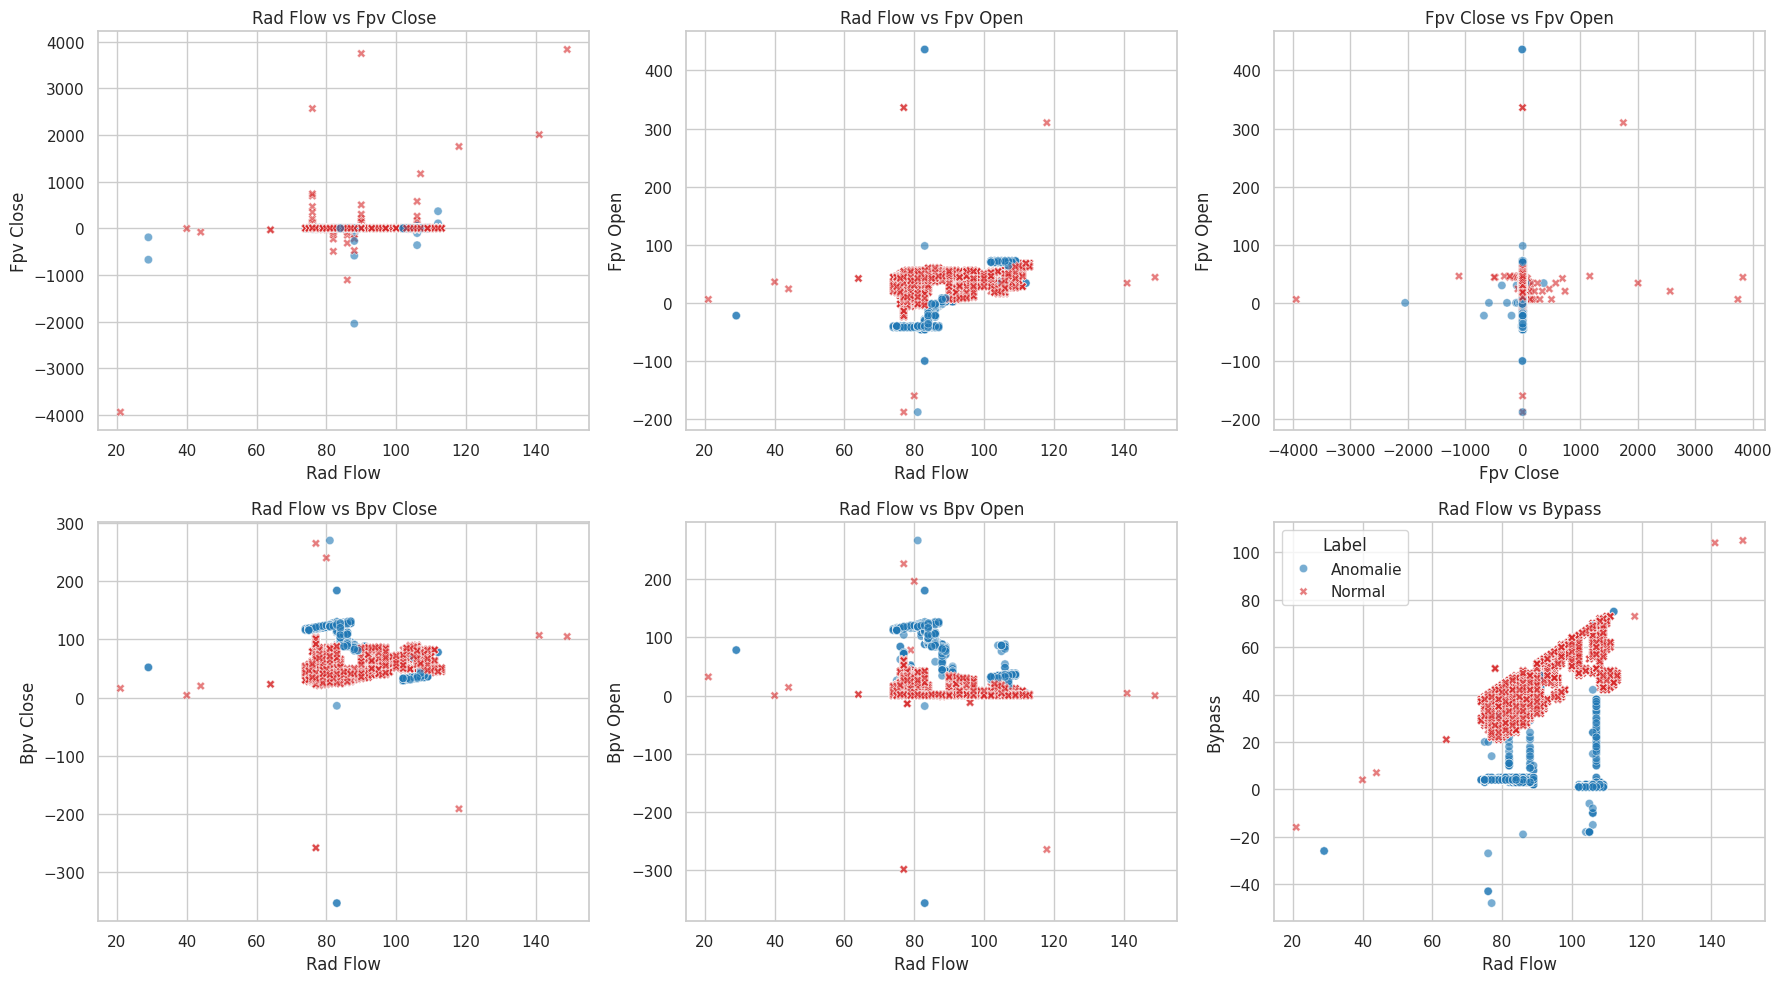

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Pregătirea datelor pentru plotare
# Concatenăm X și y temporar pentru a face graficele mai ușor de gestionat
plot_df = X.copy()
plot_df['Target'] = y['Target'].values  # 0 = Normal, 1 = Anomalie

# Redenumim etichetele pentru legendă (să arate frumos pe grafic)
plot_df['Label'] = plot_df['Target'].apply(lambda x: 'Normal' if x == 0 else 'Anomalie')

# Identificăm primele coloane disponibile (folosim .iloc pentru a fi siguri)
col_names = plot_df.columns

# Definim variabilele pentru a fi ușor de folosit în lista de perechi
feat1 = col_names[0]
feat2 = col_names[1]
feat3 = col_names[2]
feat5 = col_names[4]
feat6 = col_names[5]
feat7 = col_names[6]

# 2. Lista de perechi cerută de tine
pairs = [
    (feat1, feat2),
    (feat1, feat3),
    (feat2, feat3),
    (feat1, feat6),
    (feat1, feat7),
    (feat1, feat5)
]

# 3. Configurăm grid-ul de 2x3 (2 rânduri, 3 coloane)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten() # "Aplatizăm" matricea de axe pentru a putea itera ușor prin ea (de la 0 la 5)

# Setăm stilul
sns.set(style="whitegrid")

# 4. Iterăm prin perechi și desenăm
for i, (f_x, f_y) in enumerate(pairs):
    sns.scatterplot(
        data=plot_df,
        x=f_x,
        y=f_y,
        hue='Label',
        style='Label',
        alpha=0.6,
        ax=axes[i],
        palette=['#1f77b4', '#d62728']
    )
    axes[i].set_title(f'{f_x} vs {f_y}')

    # Opțional: Eliminăm legenda din toate graficele cu excepția ultimului pentru a nu aglomera
    if i < 5:
        axes[i].get_legend().remove()

plt.tight_layout()
plt.show()

Din graficele de mai sus reiese că, în mare parte, datele nu sunt foarte ușor separabile în forma lor actuală (cea mai clară separare între datele normale și cele anormale apare în graficul #6, și aici există regiuni de suprapunere). Așadar, am optat pentru reducerea dimensională a datelor prin PCA:


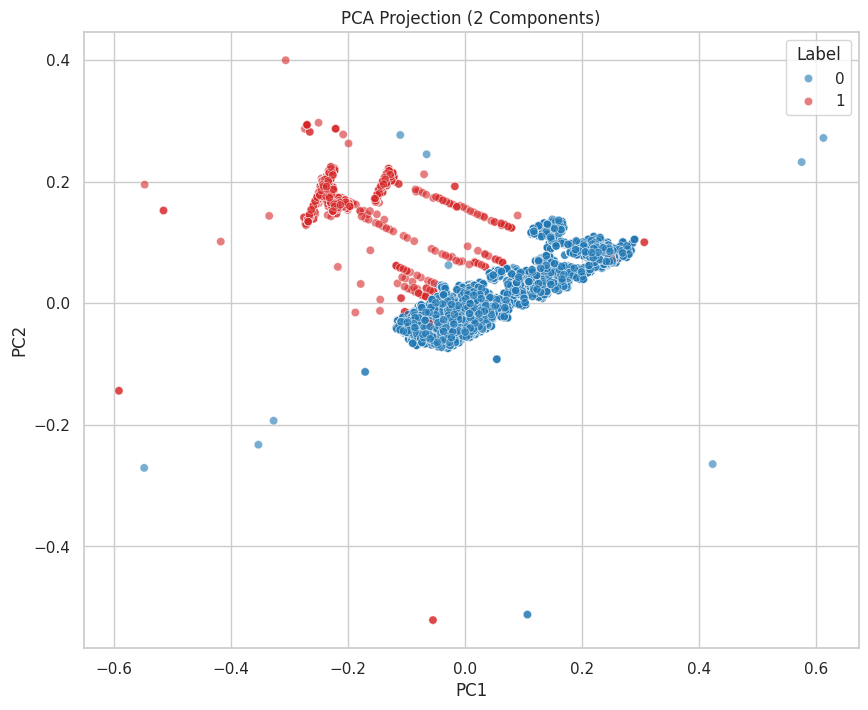

Explained Variance Ratio: [0.58104737 0.25046275]
Total Information Retained: 83.15%


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Pentru a crește performanța PCA-ului, scalez mai întâi datele mele cu MinMaxScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 1. Initialize PCA to reduce to 2 dimensions (for easy plotting)
pca_2d = PCA(n_components=2)

# 2. Fit and Transform the SCALED data (Crucial!)
# Note: Ensure you use 'X_scaled_all' (the normalized data) from previous steps
X_pca_2d = pca_2d.fit_transform(X_scaled)

# 3. Create a DataFrame for plotting
df_pca = pd.DataFrame(data=X_pca_2d, columns=['PC1', 'PC2'])
df_pca['Label'] = y['Target'].values # Add labels back

# 4. Plot the Result
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_pca, x='PC1', y='PC2', hue='Label',
    palette=['#1f77b4', '#d62728'], alpha=0.6
)
plt.title('PCA Projection (2 Components)')
plt.show()

# Optional: Print how much "information" (variance) these 2 components hold
print(f"Explained Variance Ratio: {pca_2d.explained_variance_ratio_}")
print(f"Total Information Retained: {sum(pca_2d.explained_variance_ratio_):.2%}")

Deși datele sunt mult mai ușor separabile acum, reiese din acest grafic că anomaliile pe care încercăm să le detectăm sunt de tip **cluster**, corespunzând în mare parte claselor din setul de date original.

Cu toate acestea, se observă că procentul de informație reținută este relativ redus în cazul cu 2 componente. Așadar, am încercat și PCA cu 3 componente:

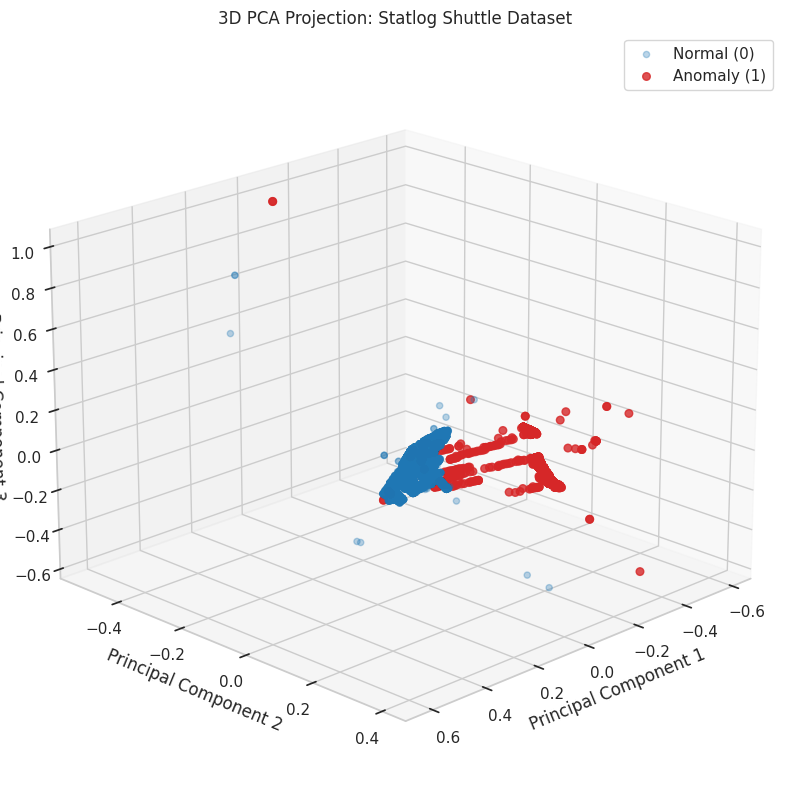

Explained Variance by Component: [0.58104737 0.25046275 0.16528645]
Total Information Retained: 99.68%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D # Necessary for 3D projection

# --- Step 1: Prepare the Data ---
# Assuming 'X' is your original features and 'y' is your Target (0/1)
# Normalize first (Critical for PCA!)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 2: Apply PCA with 3 Components ---
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Create a DataFrame for easier plotting
df_pca_3d = pd.DataFrame(data=X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca_3d['Label'] = y['Target'].values

# --- Step 3: Visualize in 3D ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Separate data for coloring
normals = df_pca_3d[df_pca_3d['Label'] == 0]
anomalies = df_pca_3d[df_pca_3d['Label'] == 1]

# Plot Normals (Blue, usually more transparent to see through the cloud)
ax.scatter(normals['PC1'], normals['PC2'], normals['PC3'],
           c='#1f77b4', label='Normal (0)', alpha=0.3, s=20)

# Plot Anomalies (Red, usually opaque to pop out)
ax.scatter(anomalies['PC1'], anomalies['PC2'], anomalies['PC3'],
           c='#d62728', label='Anomaly (1)', alpha=0.8, s=30)

# Labels and Title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Projection: Statlog Shuttle Dataset')
ax.legend()

# Optional: Change the viewing angle (Elevation, Azimuth)
ax.view_init(elev=20, azim=45)

plt.show()

# Print variance info
print(f"Explained Variance by Component: {pca_3d.explained_variance_ratio_}")
print(f"Total Information Retained: {sum(pca_3d.explained_variance_ratio_):.2%}")

Se observă că reprezentarea cu 3 componente mărește drastic procentul de informație reținută (~83% versus ~99.7%). Așadar, voi antrena modelele pe setul de date pe care s-a aplicat PCA cu 3 componente.



# 3. Descrierea metodelor de detectare a anomaliilor


## 3.1 k-Nearest Neighbors (kNN)

Algoritmul kNN care se regăsește în PyOD (numit și *kNNo* pentru a-l distinge de varianta generală [3]) reprezintă adaptarea *nesupervizată* a algoritmului de clasificare/regresie k-Nearest Neighbors la probleme de detectare a anomaliilor. În cadrul domeniului detectării de anomalii, este considerat un algoritm *distance-based*: se bazează pe presupunerea că, într-un set de date de tip numerice, datele normale sunt apropiate unele de altele, pe când anomaliile tind să se afle la o distanță mult mai mare de restul datelor.

Acesta este compus din două etape: mai întâi, calculează un **outlier score** pentru fiecare punct din setul de date pe baza celor mai apropiați *k* vecini ai acestuia. Apoi, pe baza acestor scoruri, sunt atribuite etichete binare pentru datele normale vs anomalii; această atribuire se realizează fie prin selectarea unui număr fix de outlieri, fie prin compararea fiecărui scor cu un *threshold* dat.

În PyOD, deducerea etichetelor binare din scoruri se face printr-un factor de *contaminare*, reprezentând procentul de anomalii din setul total de date (în cazul meu 0.07, deci 7%). După obținerea scorurilor, primele 7% date cu scorul sunt considerate anomalii, iar cel mai mic scor dintre ele este luat ca *threshold*. Acest threshold este luat apoi în considerare pentru evaluarea datelor de testare.

Implementarea din PyOD a algoritmului oferă 3 metode pentru calcularea **outlier score**-ului:
- 'largest', în care este luată în considerare distanța față de al k-lea cel mai apropiat vecin; este metoda de calcul folosită în articolul care a introdus pentru prima oară metoda [4];
- 'mean', care calculează media distanțelor față de primii k vecini;
- 'median', care calculează distanța mediană.

În implementarea mea, antrenez modelul kNN folosind toate cele 3 metode, evaluând performanța pentru multiple valori ale lui k.



## 3.2 Isolation Forest (IForest)

Algoritmul IForest a fost descris pentru prima dată în anul 2008 de către Liu et al., și reprezintă o abordare radical diferită față de kNN. Spre deosebire de algoritmii pe bază de distanță, care încearcă să obțină un model al datelor normale (datele care diferă de cele normale fiind considerate anomalii), IForest în schimb încearcă să izoleze *anomaliile*, valorificând mai bine caracteristicile lor cantitative [2].

Principiul de bază este că, anomaliile având valori foarte diferite față de cele normale, sunt mai ușor de izolat de restul setului de date. Astfel, un arbore  binar va putea izola o anomalie în mai puțini pași decât un element normal, deci arborii rezultanți vor avea o înălțime mai mică.

Modelul IForest este format din mai mulți astfel de arbori binari, numiți original în articol *isolation trees* (iTrees). Acești arbori partiționează recursiv setul de date în funcție de un feature anume, iar datele care sunt partiționate într-un număr mai mic de pași sunt considerate anomalii.

Unul din beneficiile algoritmului IForest este complexitatea sa de timp redusă (O(n)), fiind astfel adecvat pentru seturi de date cu o dimensionalitate mare [5]. Așadar, am antrenat algoritmul atât pe setul de date transformat prin PCA, cât și pe setul de date original, nescalat. Această alegere este justificată și prin natura setului de date: multe trăsături ale acestuia sunt statusuri reprezentate printr-un număr restrâns de numere naturale; astfel de caracteristici sunt mult mai ușor de interpretat de către algoritmul Isolation forest.



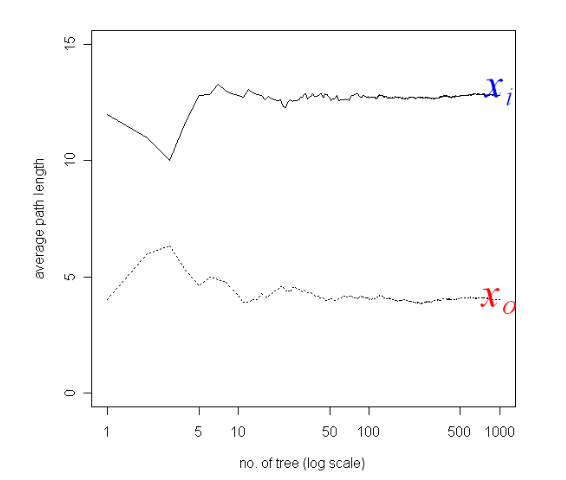

*Lungimea căii parcurse de datele normale (xi) comparate cu anomaliile (xO) în funcție de numărul total de arbori (fig. 1.c) din [2]).*


# 4. Aplicarea metodelor

Pentru evaluarea modelelor, folosesc două metrici:
- **ROC-AUC** - reprezintă aria de sub curba ROC, care plotează TPR în funcție de FPR pentru mai multe valori ale variabilei de threshold. Cu cât este mai mare această arie, cu probabiltiatea ca o anomalie să fie detectată [6];
- **Average precision score** - sumarizează relația dintre precizie (câte dintre anomaliile detectate sunt anomalii reale) și recall (câte dintre anomalii au fost identificate de model) pentru o gamă a valorilor threshold-ului.

Mai întâi împart datele în train și test folosind `train_test_split`, și aplic 3d PCA pe ele pentru a le folosi la KNN. De asemenea, extrag și PCA cu 2 componente pentru vizualizarea de după antrenare:

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train_no_pca, X_test_no_pca, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_no_pca)
X_test_scaled = scaler.transform(X_test_no_pca)


pca_3d = PCA(n_components=3)
X_train_3d = pca_3d.fit_transform(X_train_scaled)
X_test_3d = pca_3d.transform(X_test_scaled)


pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train_scaled)
X_test_2d = pca_2d.transform(X_test_scaled)


## 4.1 KNN

In [ ]:
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from sklearn.metrics import average_precision_score
import pandas as pd

# Define the list of neighbors to test
neighbors_list = [10, 20, 50, 100, 200, 300, 500, 1000, 1500]
results = []

print("kNNo - 'Largest' method ")
print(f"{'Neighbors':<12} | {'ROC-AUC':<10} | {'Avg Precision':<15}")
print("-" * 45)

y_test_scores_largest = []
for k in neighbors_list:
    clf_name = f'KNN (k={k})'

    # Initialize and train
    clf = KNN(n_neighbors=k, method='largest', n_jobs=-1)
    clf.fit(X_train_3d)

    # Prediction on test data
    y_test_scores = clf.decision_function(X_test_3d)
    y_test_scores_largest = y_test_scores #astfel, preiau în această variabilă rezultatele pentru 1500 de puncte vecine

    # Calculate Metrics
    # evaluate_print handles ROC and Precision @ Rank n
    # We manually calculate Average Precision (AP)
    ap_score = average_precision_score(y_test, y_test_scores)

    # Extracting ROC from PyOD's internal utility (or calculating manually)
    from sklearn.metrics import roc_auc_score
    roc_score = roc_auc_score(y_test, y_test_scores)

    print(f"{k:<12} | {roc_score:<10.4f} | {ap_score:<15.4f}")

    # Store for later analysis or plotting
    results.append({'k': k, 'ROC': roc_score, 'AP': ap_score})

#fac același lucru pentru "mean" și "median"

print("\nkNNo - 'Mean' method ")
print(f"{'Neighbors':<12} | {'ROC-AUC':<10} | {'Avg Precision':<15}")
print("-" * 45)

for k in neighbors_list:
    clf_name = f'KNN (k={k})'


    clf = KNN(n_neighbors=k, method='mean', n_jobs=-1)
    clf.fit(X_train_3d)

    y_test_scores = clf.decision_function(X_test_3d)
    ap_score = average_precision_score(y_test, y_test_scores)

    from sklearn.metrics import roc_auc_score
    roc_score = roc_auc_score(y_test, y_test_scores)

    print(f"{k:<12} | {roc_score:<10.4f} | {ap_score:<15.4f}")

    results.append({'k': k, 'ROC': roc_score, 'AP': ap_score})


print("\nkNNo - 'Median' method ")
print(f"{'Neighbors':<12} | {'ROC-AUC':<10} | {'Avg Precision':<15}")
print("-" * 45)

for k in neighbors_list:
    clf_name = f'KNN (k={k})'

    clf = KNN(n_neighbors=k, method='median', n_jobs=-1)
    clf.fit(X_train_3d)

    y_test_scores = clf.decision_function(X_test_3d)

    ap_score = average_precision_score(y_test, y_test_scores)

    from sklearn.metrics import roc_auc_score
    roc_score = roc_auc_score(y_test, y_test_scores)

    print(f"{k:<12} | {roc_score:<10.4f} | {ap_score:<15.4f}")

    results.append({'k': k, 'ROC': roc_score, 'AP': ap_score})

# Optional: Convert to DataFrame to see best k at a glance
results_df = pd.DataFrame(results)
best_k = results_df.loc[results_df['AP'].idxmax(), 'k']
print(f"\nBest number of neighbors based on Average Precision: {best_k}")

kNNo - 'Largest' method 
Neighbors    | ROC-AUC    | Avg Precision  
---------------------------------------------
10           | 0.6577     | 0.1653         
20           | 0.6821     | 0.1681         
50           | 0.6725     | 0.1632         
100          | 0.7219     | 0.1789         
200          | 0.7805     | 0.1954         
300          | 0.8378     | 0.2268         
500          | 0.8714     | 0.2538         
1000         | 0.9662     | 0.7185         
1500         | 0.9825     | 0.8572         

kNNo - 'Mean' method 
Neighbors    | ROC-AUC    | Avg Precision  
---------------------------------------------
10           | 0.6500     | 0.1686         
20           | 0.6781     | 0.1732         
50           | 0.6858     | 0.1688         
100          | 0.6966     | 0.1707         
200          | 0.7372     | 0.1811         
300          | 0.7776     | 0.1962         
500          | 0.8344     | 0.2238         
1000         | 0.9204     | 0.5220         
1500         | 0.9691   

Din aceste tabele, se pot extrage mai multe concluzii:
- Pentru setul de date actual, metrica „largest” este cea mai adecvată, discrepanța crescând pe măsură ce adăugăm mai multe puncte vecine;
- Performanța algoritmului crește semnificativ odată cu numărul de vecini care sunt luați în considerare; acest lucru era de așteptat, având în vedere că anomaliile sunt dispuse în grafic în mare parte sub formă de *clustere*; dacă k-ul e prea mic, atunci aceste anomalii apropiate între ele vor fi considerate date normale de către kNN;
- În fiecare model, există o discrepanță destul de mare scorul dat de ROC și cel dar de average_precision; acest lucru se explică prin penalizarea mai aspră a erorilor de tip *false positive* acestei metrici în comparație cu ROC.

Vizualizez diferențele dintre ground truth și rezultatele date de KNN (1500 de vecini, `largest`) folosind PCA:

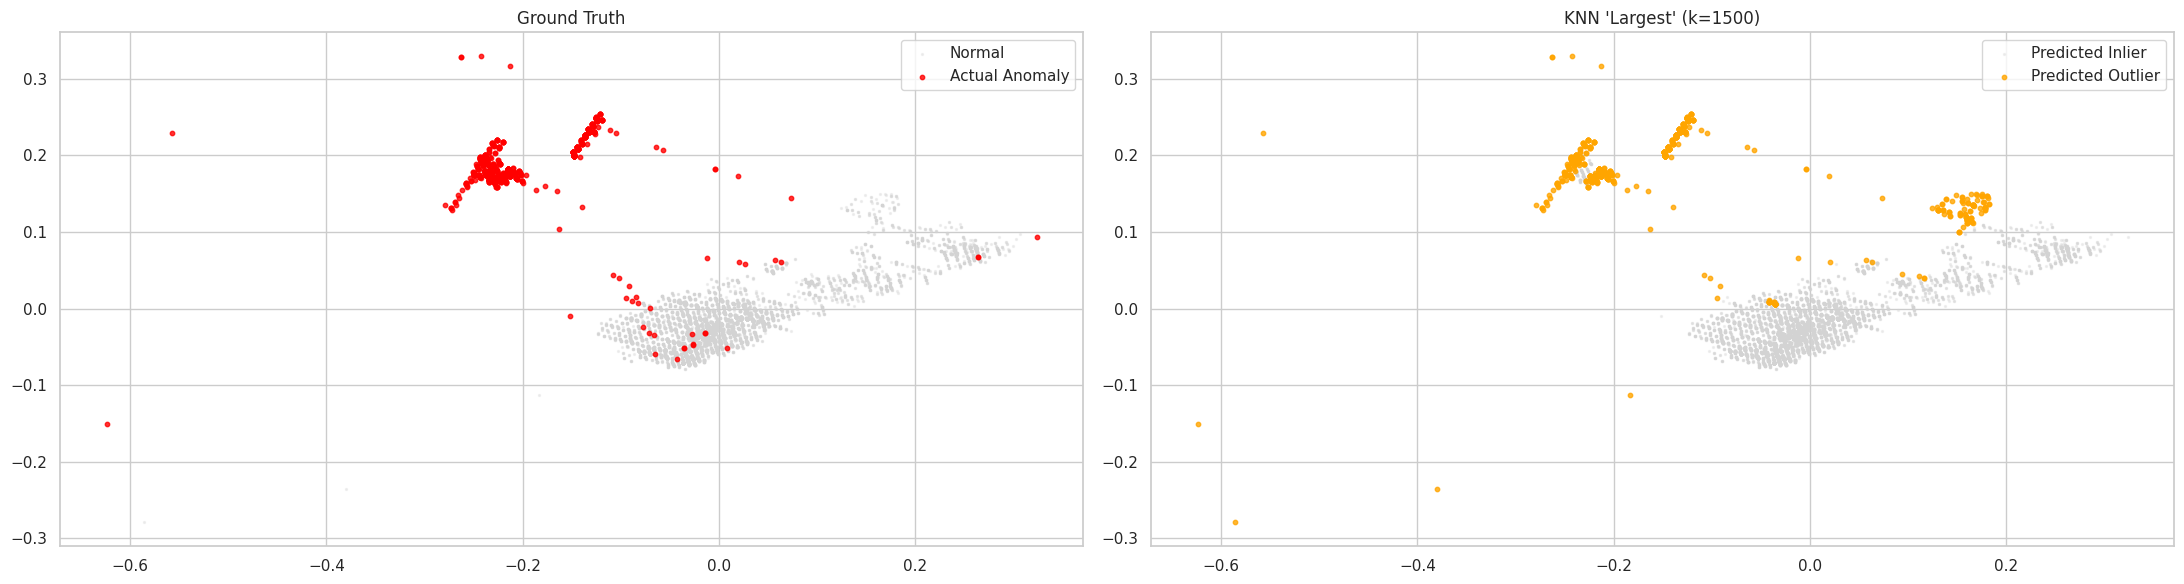

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc

threshold = np.percentile(y_test_scores_largest, 100 * (1 - 0.07))
y_test_pred_binary = (y_test_scores_largest > threshold).astype(int)


# 1. Extract masks (handling Pandas Series vs NumPy)
mask_normal = (y_test.values == 0).flatten()
mask_anomaly = (y_test.values == 1).flatten()
mask_pred_inlier = (y_test_pred_binary == 0).flatten()
mask_pred_outlier = (y_test_pred_binary == 1).flatten()


# 2. Calculate ROC for the third plot
fpr, tpr, _ = roc_curve(y_test, y_test_scores_largest)
roc_auc = auc(fpr, tpr)

# --- Create the 2-Panel Plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))

# Subplot 1: Ground Truth
ax1.scatter(X_test_2d[mask_normal, 0], X_test_2d[mask_normal, 1],
            c='lightgrey', label='Normal', s=2, alpha=0.3)
ax1.scatter(X_test_2d[mask_anomaly, 0], X_test_2d[mask_anomaly, 1],
            c='red', label='Actual Anomaly', s=10, alpha=0.8)
ax1.set_title("Ground Truth")
ax1.legend()

# Subplot 2: KNN 'Largest' Predictions
ax2.scatter(X_test_2d[mask_pred_inlier, 0], X_test_2d[mask_pred_inlier, 1],
            c='lightgrey', label='Predicted Inlier', s=2, alpha=0.3)
ax2.scatter(X_test_2d[mask_pred_outlier, 0], X_test_2d[mask_pred_outlier, 1],
            c='orange', label='Predicted Outlier', s=10, alpha=0.8)
ax2.set_title(f"KNN 'Largest' (k=1500)")
ax2.legend()


plt.tight_layout()
plt.show()

De remarcat este clusterul de puncte din stânga graficului care a fost clasificat (în mod eronat) drept cluster de anomalii de KNN. Chiar și cu 1500 de vecini, algoritmul identifică false positives in numere suficient de mari încât să afecteze precizia algoritmului

## 4.2 IForest

In [ ]:
from pyod.models.iforest import IForest
from pyod.utils.data import evaluate_print
from sklearn.metrics import average_precision_score, roc_auc_score
import pandas as pd

# Define the list of tree counts to test
estimators_list = [50, 100, 200, 500, 1000]
results_if = []


actual_contamination = 0.07 # 7%

print(f"{'Trees':<10} | {'ROC-AUC':<10} | {'Avg Precision':<15}")
print("-" * 40)

for n in estimators_list:
    clf_name = f'IForest ({n} trees)'

    # Initialize and train
    # n_jobs=-1 uses all CPU cores for faster forest building
    model = IForest(n_estimators=n, contamination=actual_contamination, random_state=42, n_jobs=-1)
    model.fit(X_train_3d)

    # Get outlier scores (decision_function returns raw anomaly scores)
    y_test_scores = model.decision_function(X_test_3d)

    # Calculate metrics
    roc = roc_auc_score(y_test, y_test_scores)
    ap = average_precision_score(y_test, y_test_scores)

    print(f"{n:<10} | {roc:<10.4f} | {ap:<15.4f}")

    results_if.append({'Trees': n, 'ROC': roc, 'AP': ap})

# Final Summary
results_df = pd.DataFrame(results_if)
print(f"\nBest Tree Count (by AP): {results_df.loc[results_df['AP'].idxmax(), 'Trees']}")

Trees      | ROC-AUC    | Avg Precision  
----------------------------------------
50         | 0.9836     | 0.8658         
100        | 0.9849     | 0.8832         
200        | 0.9854     | 0.8920         
500        | 0.9856     | 0.8949         
1000       | 0.9856     | 0.8944         

Best Tree Count (by AP): 500


In [ ]:
from pyod.models.iforest import IForest
from pyod.utils.data import evaluate_print
from sklearn.metrics import average_precision_score, roc_auc_score
import pandas as pd

# Define the list of tree counts to test
estimators_list = [50, 100, 200, 500, 1000]
results_if = []


actual_contamination = 0.07 # 7%

print(f"{'Trees':<10} | {'ROC-AUC':<10} | {'Avg Precision':<15}")
print("-" * 40)

for n in estimators_list:
    clf_name = f'IForest ({n} trees)'

    # Initialize and train
    # n_jobs=-1 uses all CPU cores for faster forest building
    model = IForest(n_estimators=n, contamination=actual_contamination, random_state=42, n_jobs=-1)
    model.fit(X_train_no_pca.values)

    # Get outlier scores (decision_function returns raw anomaly scores)
    y_test_scores = model.decision_function(X_test_no_pca.values)

    # Calculate metrics
    roc = roc_auc_score(y_test, y_test_scores)
    ap = average_precision_score(y_test, y_test_scores)

    print(f"{n:<10} | {roc:<10.4f} | {ap:<15.4f}")

    results_if.append({'Trees': n, 'ROC': roc, 'AP': ap})

# Final Summary
results_df = pd.DataFrame(results_if)
print(f"\nBest Tree Count (by AP): {results_df.loc[results_df['AP'].idxmax(), 'Trees']}")

Trees      | ROC-AUC    | Avg Precision  
----------------------------------------
50         | 0.9858     | 0.9171         
100        | 0.9877     | 0.9457         
200        | 0.9874     | 0.9425         
500        | 0.9879     | 0.9455         
1000       | 0.9872     | 0.9366         

Best Tree Count (by AP): 100


Din aceste rezultate reies următoarele observații:
- Pe acest set de date, așa cum am anticipat, reducerea dimensională cu PCA afectează performanța algoritmului, formatul inițial al datelor fiind adecvat pentru modelarea prin arbori binari;
- În ambele cazuri, algoritmul este robust față de numărul de arbori de decizie folosiți.

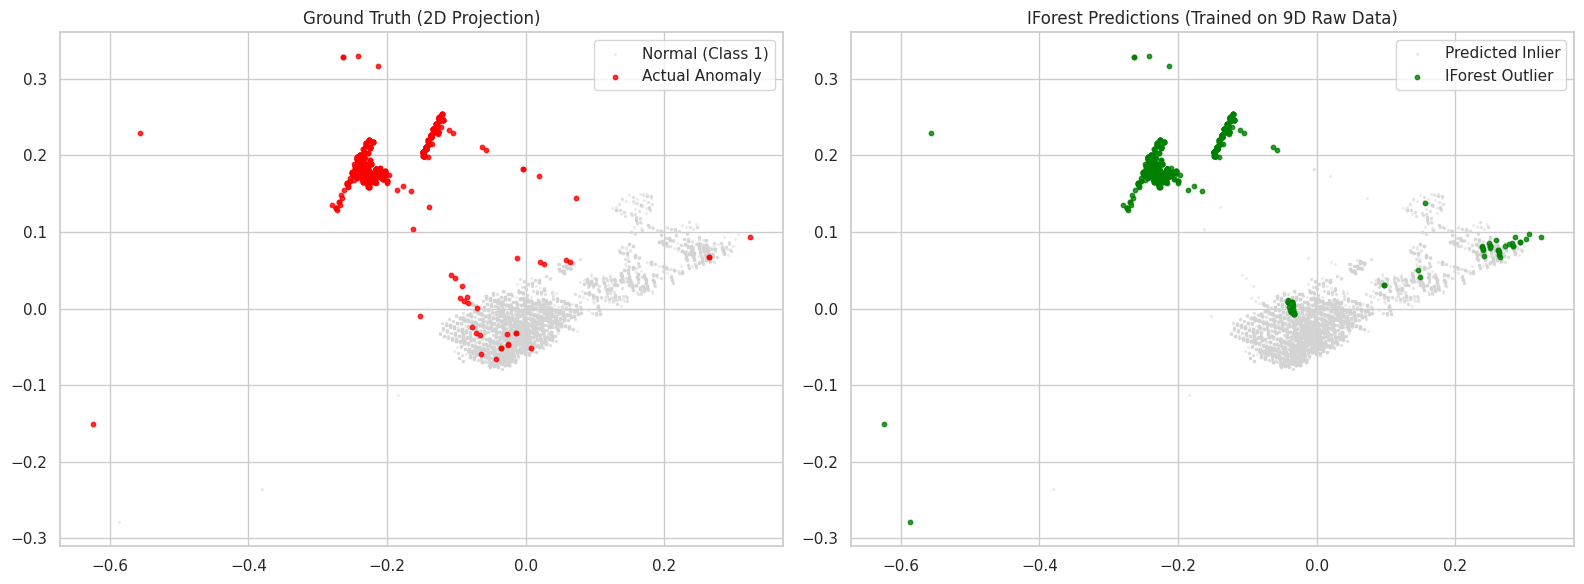

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# 1. Train the best version of IForest (Non-PCA, 100 trees)
# Using .values as discussed to avoid feature name warnings
best_if = IForest(n_estimators=100, contamination=0.07, random_state=42, n_jobs=-1)
best_if.fit(X_train_no_pca.values)

# 2. Get predictions and scores for the test set
y_test_scores_if = best_if.decision_function(X_test_no_pca.values)
y_test_pred_if = best_if.predict(X_test_no_pca.values) # PyOD returns 1 for anomaly, 0 for inlier

# 3. Prepare masks for plotting
mask_normal = (y_test.values == 0).flatten()
mask_anomaly = (y_test.values == 1).flatten()
mask_pred_inlier = (y_test_pred_if == 0).flatten()
mask_pred_outlier = (y_test_pred_if == 1).flatten()

# 4. Create the Comparison Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Subplot 1: Ground Truth ---
ax1.scatter(X_test_2d[mask_normal, 0], X_test_2d[mask_normal, 1],
            c='lightgrey', label='Normal (Class 1)', s=2, alpha=0.3)
ax1.scatter(X_test_2d[mask_anomaly, 0], X_test_2d[mask_anomaly, 1],
            c='red', label='Actual Anomaly', s=10, alpha=0.8)
ax1.set_title("Ground Truth (2D Projection)")
ax1.legend()

# --- Subplot 2: Non-PCA IForest Predictions ---
ax2.scatter(X_test_2d[mask_pred_inlier, 0], X_test_2d[mask_pred_inlier, 1],
            c='lightgrey', label='Predicted Inlier', s=2, alpha=0.3)
ax2.scatter(X_test_2d[mask_pred_outlier, 0], X_test_2d[mask_pred_outlier, 1],
            c='green', label='IForest Outlier', s=10, alpha=0.8)
ax2.set_title("IForest Predictions (Trained on 9D Raw Data)")
ax2.legend()

plt.tight_layout()
plt.show()

De remarcat este că, în comparație cu KNN, nu a mai preluat clusterul de puncte din stânga, IForest nefiind o metodă care să țină cont de distanțe. Totuși, nu a preluat (puținele) puncte dintre clusterul principal de date normale și clusterele de anomalii. Aflându-se între două clustere mari, sunt mai greu de izolat de către IForest.

Într-un final, compar metodele KNN și IForest folosind și Silhouette score din sk_learn, acesta reprezentând o valoare între -1 și 1; valorile pozitive indică faptul că fiecare punct se potrivește bine în clusterul său, pe când valorile negative ar sugera că punctele ajung în clusterele greșite:


In [ ]:
from sklearn.metrics import silhouette_score


sil_knn = silhouette_score(X_test_3d, y_test_pred_binary)
sil_if = silhouette_score(X_test_no_pca.values, y_test_pred_if)

print(f"Silhouette Score for KNN: {sil_knn}")
print(f"Silhouette Score for IForest: {sil_if}")

Silhouette Score for KNN: 0.5864887896710742
Silhouette Score for IForest: 0.6515825230918282


Având un Silhouette Score > 0.5, ambele modele demonstrează o bună separare a datelor normale față de anomalii. Ca și cu celelalte metrici, IForest are o performanță superioară.

# 5. Concluzii

- Setul de date a conținut predominant anomalii de tip *cluster*, corespunzând claselor originale din versiunea originală a acestuia;
- Din această cauză, algoritmul KNN nu a reușit să separe anomaliile de restul datelor pentru valori ale lui k mici; a reușit să obțină performanțe acceptabile folosind > 1000 de vecini, fiind punctul în care modelul a putut distinge mai clar între clusterele de anomalii și clusterele de date normale;
- Performanța algoritmului IForest a fost afectată semnificativ de către reducerea dimensională cu PCA. Multe dintre caraceristicile originale ale datelor reprezentau statusuri ușor de învățat de către IForest; prin reducerea dimensională, IForest nu s-a mai putut folosi de aceste trăsături ale setului de date original;
- Per total, algoritmul IForest a avut performanțe mai bune pe setul de date decât KNN conform tuturor metricilor aplicate;
- Cu toate acestea, inspecția vizuală a arătat că ambele metode au avut probleme în a recunoaște anumite tipuri de anomalii recunoscute de celălalt model; astfel, ambele au avut un aport informațional, combinarea acestora contribuind la o înțelegere mai robustă a setului de date.

## 6. Bibliografie

[1]. Naoki Abe, Bianca Zadrozny, and John Langford. 2006. Outlier detection by active learning. In Proceedings of the 12th ACM SIGKDD international conference on Knowledge discovery and data mining (KDD '06). Association for Computing Machinery, New York, NY, USA, 504–509. https://doi.org/10.1145/1150402.1150459

[2]. F. T. Liu, K. M. Ting and Z. -H. Zhou, "Isolation Forest," 2008 Eighth IEEE International Conference on Data Mining, Pisa, Italy, 2008, pp. 413-422, doi: 10.1109/ICDM.2008.17.

[3]. [kNN for outlier detection - R Documentation](https://search.r-project.org/CRAN/refmans/adamethods/html/do_knno.html)

[4]. Sridhar Ramaswamy, Rajeev Rastogi, and Kyuseok Shim. 2000. Efficient algorithms for mining outliers from large data sets. SIGMOD Rec. 29, 2 (June 2000), 427–438. https://doi.org/10.1145/335191.335437

  
[5]. Charu C. Aggarwal, (2016) Outlier Analysis, 2nd edition, Springer, pg. 161-163

[6]. [Classification: ROC and AUC - Google Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)